In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import sys
from collections import Counter

In [14]:
df = pd.read_excel('PYRITE HANDLING SYS.xlsx')
df_wordfreq = pd.read_excel('단어사전.xlsx')

In [15]:
df_ess = df[['TM제목','진행상태','발행일자','설비번호']]

In [16]:
import re

def preprocess_text2(text):
    # 1. 텍스트를 소문자로 변환
    text = text.lower()
    
    # 2. '/' 문자를 제거하여 's/w'를 'sw'로 변환
    text = text.replace('/', '')
    
    # 3. 특수문자를 공백으로 대체 (단, #은 유지)
    text = re.sub(r"[^\w\s#]", " ", text)
    
    # 4. 숫자 제거
    text = re.sub(r"\d+", " ", text)
    
    # 5. 한글-영어, 영어-한글 붙어 있는 경우 분리
    patterns = [
        r'([ㄱ-ㅎㅏ-ㅣ가-힣]+)([a-zA-Z]+)', 
        r'([a-zA-Z]+)([ㄱ-ㅎㅏ-ㅣ가-힣]+)'
    ]
    for pattern in patterns:
        text = re.sub(pattern, r'\1 \2', text)

    # 6. 공백을 기준으로 단어들을 리스트로 분리
    word_list = text.split()

    # 7. 단어 필터링 및 불필요한 단어 제거
    filtered_words = []
    replace_words = ['호기', '번', '개', '제어', '측', '층', '및', '부', '위치', '내']
    
    for word in word_list:
        if word.startswith('#'):
            # '#' 단독 또는 '#' 뒤에 숫자가 오면 단어 삭제
            if len(word) == 1 or (len(word) > 1 and word[1].isdigit()):
                continue
            else:
                filtered_words.append(word)
        else:
            # 'csu'가 포함된 단어는 제거
            if 'csu' in word:
                continue
            # 특정 단어를 제거
            original_word = word
            for replace_word in replace_words:
                if word == replace_word:
                    word = word.replace(replace_word, '')
            # 'ea'와 빈 문자열 제외
            if word != 'ea' and word != '':
                filtered_words.append(word if word != '' else original_word)

    # 8. 1글자 이하의 단어 제거
    # filtered_words = [word for word in filtered_words if len(word) > 1]

    # 9. 반복되는 단어 제거
    unique_words = []
    for word in filtered_words:
        if word not in unique_words:
            unique_words.append(word)

    # 10. 전처리된 단어 리스트를 다시 텍스트 형태로 변환
    return ' '.join(unique_words)

# 테스트 텍스트
text = '#5 Pyrites Hopper #A Screen 마모 s/w 상부'
print(preprocess_text2(text))


pyrites hopper #a screen 마모 sw 상부


In [17]:
df_ess['TM제목'] = df_ess['TM제목'].apply(preprocess_text2)

df_ess['TM제목'].to_csv('클렌징만.csv',index=False, encoding='utf-8-sig')

C:\Users\Parkjeongin\AppData\Local\Temp\ipykernel_16948\1385606966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ess['TM제목'] = df_ess['TM제목'].apply(preprocess_text2)


In [18]:
df_ess['TM제목']

0           pyrites hopper #a b hp suction valve passing
1                         pyrites hopper #e 내부 screen 마모
2              pyrites hopper #d ejector flange wtr leak
3      pyrites hopper disch line tr tank 상부 pe 관 pinhole
4                            pyrites hopper #c 점검등 점등 불량
                             ...                        
477           pyrites hopper #a c high level sensor 동작불량
478             pyrites hopper discharge line pe 관 crack
479         pyrites hopper disch line pinhole tr tank 상부
480                       pyrites hopper #d pe 관 pinhole
481              제 pulv #e #f pyrite hp wtr pr gauge 오지시
Name: TM제목, Length: 482, dtype: object

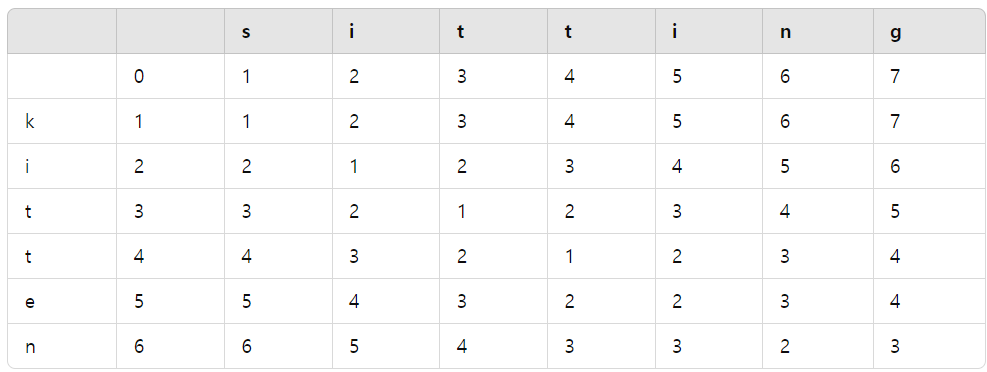

kitten을 sitting으로 바꾸는 데 필요한 비용은 3

In [19]:
# Damerau-Levenshtein Distance (위의 예시 참고)

# 이 함수는 오타가 있는 단어와 정답인 단어가 몇글자나 다른지(편집거리) 계산하는 것
# s1 = kitten s2 = sitting 이라고 생각하면, 
def damerau_levenshtein_distance(s1, s2):
    
    #일단 딕셔너리 초기화 하고(편집거리를 저장하는 용도)
    d = {}
    # lenstr1 = 6, lenstr2 = 7
    lenstr1 = len(s1)
    lenstr2 = len(s2)

    #s1 단어의 i번째 글자로 삭제 하기위해서 i번 삭제 과정을 거치겠다 (s1단어와 빈 문자열을 비교하는 것)를 순서대
    for i in range(-1, lenstr1 + 1):
        d[(i, -1)] = i + 1
    #s2 단어의 j번째 글자를 순서대로 삽입 하기위해서 j번 삽입 과정을 거치겠다 (빈 문자열과 s2 단어를 비교하는 것)       
    for j in range(-1, lenstr2 + 1):
        d[(-1, j)] = j + 1

    #두 단어 사이에 편집 거리를 계산
    for i in range(lenstr1):
        for j in range(lenstr2):

            #만약 현재 위치 문자가 같으면 비용은0, 다르면 1
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            #해당 위치에서, 한글자를 삭제, 삽입, 대체하는 비용은 1
            d[(i, j)] = min(
                d[(i - 1, j)] + 1,  # deletion
                d[(i, j - 1)] + 1,  # insertion
                d[(i - 1, j - 1)] + cost  # substitution
            )
            #전치도 고려하겠다 (자리 바꿨을 때 ex- asd <->dsa 이면, 대체2로 비용이 2이겠지만, 전치를 고려하면 a와 d를 바꾸는 비용1만 발생)
            if i and j and s1[i] == s2[j - 1] and s1[i - 1] == s2[j]:
                d[(i, j)] = min(d[(i, j)], d[(i - 2, j - 2)] + cost)  # transposition

    return d[lenstr1 - 1, lenstr2 - 1]

# 단어 사전 가져와서 딕셔너리로 변경
def create_dictionary(df_dict):
    return pd.Series(df_dict['빈도'].values, index=df_dict['단어']).to_dict()

# 단어 교정 함수
def correct_word(word, dictionary, n_gram_context=None, max_distance_scale=1.0):
    if not re.match(r'^[a-zA-Z]+$', word):  # 영어 단어가 아니면 수정하지 않고 반환
        return word
    
    max_distance = min(len(word), 4) * max_distance_scale #  단어 길이가 4 이하라면, 최대 교정 거리를 단어 길이로 설정, 4보다 길면 4로 고정.
    min_distance = float('inf')
    corrected_word = word

    #사전에 있는 단어와 해당 단어의 레벤슈타인 거리를 계산. 
    for dict_word, freq in dictionary.items():
        distance = damerau_levenshtein_distance(word, dict_word)
        
        if n_gram_context: #n_gram(좀 더 적합한 단어를 미리 정해두는 것) 설정을 안했으니까 무시해도 됨
            if dict_word in n_gram_context:
                distance -= 0.5
        
        # 현재 거리보다 더 짧은 거리를 가지는 단어가 있다면 가장 거리가 짧은 것으로 고치겠다.(즉, 단어가 등재되어있으면 거리는 0이니까 교정이 안됨)
        # 만약 더 짧은 거리를 가지는 단어가 여러개면, 더 단어사전에서 빈도가 많았던 것으로 바꾸겠다. (그럴 가능성이 높으니까)
        if distance < min_distance or (distance == min_distance and dictionary[corrected_word] < freq):
            if distance <= max_distance:
                min_distance = distance
                corrected_word = dict_word
    # 최대 교정 거리 미만일때만 바꾸겠다. (ex- asd -> fgh (안바꿈. 이건 새로운 단어일 것같음), asdfg -> zxcvg (역시 안바꿈. 최대 거리가 4니까.))
    return corrected_word if min_distance < max_distance else word


# 단어 사전 설정
dictionary = create_dictionary(df_wordfreq)


# 교정 함수 적용
def correct_text(text):
    words = text.split()
    corrected_words = []
    for prev_word, word in zip([''] + words, words):
        corrected_word = correct_word(word, dictionary, None, 1.5)
        corrected_words.append(corrected_word)
    return ' '.join(corrected_words)

# 데이터프레임 열에 함수 적용
df_ess['교정TM제목'] = df_ess['TM제목'].apply(correct_text)

print(df_ess[['TM제목', '교정TM제목']])

                                                  TM제목  \
0         pyrites hopper #a b hp suction valve passing   
1                       pyrites hopper #e 내부 screen 마모   
2            pyrites hopper #d ejector flange wtr leak   
3    pyrites hopper disch line tr tank 상부 pe 관 pinhole   
4                          pyrites hopper #c 점검등 점등 불량   
..                                                 ...   
477         pyrites hopper #a c high level sensor 동작불량   
478           pyrites hopper discharge line pe 관 crack   
479       pyrites hopper disch line pinhole tr tank 상부   
480                     pyrites hopper #d pe 관 pinhole   
481            제 pulv #e #f pyrite hp wtr pr gauge 오지시   

                                                교정TM제목  
0         pyrites hopper #a b hp suction valve passing  
1                       pyrites hopper #e 내부 screen 마모  
2            pyrites hopper #d ejector flange wtr leak  
3    pyrites hopper disch line tr tank 상부 pe 관 pinhole  
4                 

C:\Users\Parkjeongin\AppData\Local\Temp\ipykernel_16948\984893243.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ess['교정TM제목'] = df_ess['TM제목'].apply(correct_text)


In [20]:
df_ess = df_ess[df_ess['진행상태'] == 'TM종결']

df_ess.reset_index(drop = True)

,TM제목,진행상태,발행일자,설비번호,교정TM제목
0,pyrites hopper #c 점검등 점등 불량,TM종결,2023-03-05,10605700,pyrites hopper #c 점검등 점등 불량
1,pyrites hopper d screen 마모,TM종결,2023-02-27,10605760,pyrites hopper d screen 마모
2,pyrites hopper #a 내부철망 마모,TM종결,2023-02-19,10605580,pyrites hopper #a 내부철망 마모
3,pyrites hopper #d high level 오지시,TM종결,2023-01-29,10605810,pyrites hopper #d high level 오지시
4,pyrites hopper #b hp water suction valve opnec...,TM종결,2023-01-23,10606010,pyrites hopper #b hp water suction valve opnec...
...,...,...,...,...,...
449,pyrites hopper #a c high level sensor 동작불량,TM종결,2012-10-25,10605630,pyrites hopper #a c high level sensor 동작불량
450,pyrites hopper discharge line pe 관 crack,TM종결,2012-09-27,10605940,pyrites hopper discharge line pe 관 crack
451,pyrites hopper disch line pinhole tr tank 상부,TM종결,2012-08-30,10605940,pyrites hopper disch line pinhole tr tank 상부
452,pyrites hopper #d pe 관 pinhole,TM종결,2012-06-22,10606130,pyrites hopper #d pe 관 pinhole


In [24]:
df_ess.to_excel('교정후TM.xlsx',index=False)